In [1235]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
from utils import constants as cnst
from wavelet import util, wav
from scipy.ndimage.measurements import label
from scipy import ndimage
from utils import u_arrays as ua
import numpy.ma as ma
from eod import mfg

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1236]:
cd ..

/home/ck/pythonWorkspace


In [1237]:
msg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_-40_700km2_-50points_dominant_2004_09.nc'
msg_avg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_avgInter_MSG_-40_700km2_-50points_dominant_2004_09.nc'
mfg_file = '/home/ck/DIR/cornkle/data/vera_test/cores_MFG_-40_700km2_-50points_dominant_2004_09.nc'

In [1238]:
ar_msg = xr.open_dataset(msg_file)
ar_msg = xr.open_dataset(msg_avg_file) 
ar_mfg = xr.open_dataset(mfg_file)

In [1329]:
day=245
tmsg = ar_msg.isel(time=day)
tmsg_avg = ar_avg_msg.isel(time=day)
tmfg = ar_mfg.isel(time=day)

tmsg['tir'].values = tmsg['tir']/100
tmsg_avg['tir'].values = tmsg_avg['tir']/100
tmfg['tir'].values = tmfg['tir']/100

tmsg['tir'].values[tmsg['tir'].values>=-40] = 0
tmsg_avg['tir'].values[tmsg_avg['tir'].values>=-40] = 0
tmfg['tir'].values[tmfg['tir'].values>=-40] = 0

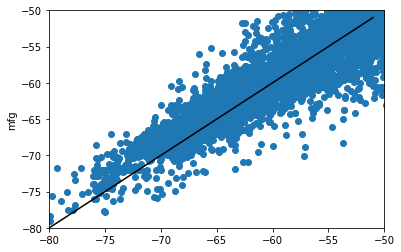

In [1330]:
plt.scatter(tmsg['tir'], tmfg['tir'])
plt.ylim(-80,-50)
plt.xlim(-80,-50)
plt.ylabel('mfg')
plt.plot(np.arange(-80,-50,1),np.arange(-80,-50,1), 'k-')

In [1331]:
def normalised(data, mini, maxi):
        return (data - mini) / abs(maxi - mini)

def single_degree(mini, maxi):
    return 1/abs(maxi-mini)

In [1332]:
core_msg

<xarray.Dataset>
Dimensions:         (lat: 296, lon: 674)
Coordinates:
    time            datetime64[ns] 2004-09-05T17:00:00
  * lon             (lon) float64 -17.68 -17.64 -17.59 ... 12.45 12.5 12.54
  * lat             (lat) float64 3.912 3.957 4.003 4.048 ... 16.91 16.95 17.0
Data variables:
    blobs           (lat, lon) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    tir             (lat, lon) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    power15-19km    (lat, lon) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    power32-38km    (lat, lon) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    power80-90km    (lat, lon) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    power160-170km  (lat, lon) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
Attributes:
    radii:              [ 2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  ...
    scales_rounded:     [ 15  16  17  18  19  20  21  22  24  25  27  28  30 ...
    scales_original:    [ 15.          15.89194642  16.

In [1333]:
def filter_img(inarr):
    
        outt = inarr.copy()*-1
        print('outmin', np.nanmin(outt), np.nanmax(outt))
        
        t_thresh_size = 40
        t_thresh_cut = 50
        
        
        #core_min = -60

        outt[outt<=t_thresh_size] = 0
        outt[np.isnan(outt)] = 0

        labels, numL = label(outt)

        u, inv = np.unique(labels, return_inverse=True)
        n = np.bincount(inv)

        pix_nb = 28

        badinds = u[(n < pix_nb)]  # all blobs with more than 1000 pixels = 25,000km2 (meteosat regridded 5km), 200pix = 5000km2, 8pix = 200km2
        # scale 30km, radius 15km ca. 700km2 circular area equals 28 pix

        for bi in badinds:
            inds = np.where(labels == bi)
            outt[inds] = 0
        
        out_nogood = outt==0
        mini = t_thresh_cut
        maxi = np.nanmax(outt)
        
        gradnorm = 150
        outt[outt <=t_thresh_cut] = gradnorm

        grad = np.gradient(outt)
        outt[outt == gradnorm] = np.nan

        nogood = np.isnan(outt) # filters edge maxima later, no maxima in -40 edge area by definition!
        
        outt = normalised(outt, mini, maxi)
        
        xmin=10*single_degree(mini,maxi)
        print('xmin', xmin)
        #print('bla', normalised(t_thresh_cut, mini, maxi))
        outt[nogood] = normalised(t_thresh_cut, mini, maxi)+xmin
        
        print(grad[0])
        nok = np.where(abs(grad[0]) > 80)
        d = 2
        i = nok[0]
        j = nok[1]
        #edge smoothing for wavelet application
        for ii, jj in zip(i, j):
            kern = outt[ii - d:ii + d + 1, jj - d:jj + d + 1]
            outt[ii - d:ii + d + 1, jj - d:jj + d + 1] = ndimage.gaussian_filter(kern, 2, mode='nearest')
        
        
        return outt, out_nogood, mini, maxi

In [1334]:
np.setdiff1d(ar_mfg['time'].values, ar_msg['time'].values)

array(['2004-09-29T01:00:00.000000000', '2004-09-29T01:30:00.000000000'],
      dtype='datetime64[ns]')

In [1335]:
x1 = 50
x2 = 690
y1 = 50
y2 = 250
x1 = 0
x2 =690
y1 = 0
y2 = 300

In [1336]:
mfg_imgg = (tmfg['tir'].values)[y1:y2,x1:x2] #[5,y1:y2,x1:x2]/100
msg_imgg = (tmsg['tir'].values)[y1:y2,x1:x2]

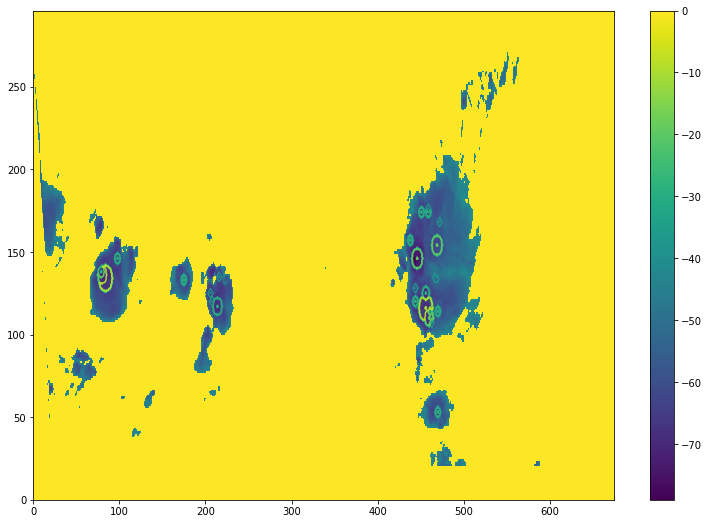

In [1337]:
plt.figure(figsize=(13,9))
plt.pcolormesh(mfg_imgg)
plt.colorbar()
plt.contour(ar_mfg['blobs'][day,y1:y2,x1:x2])


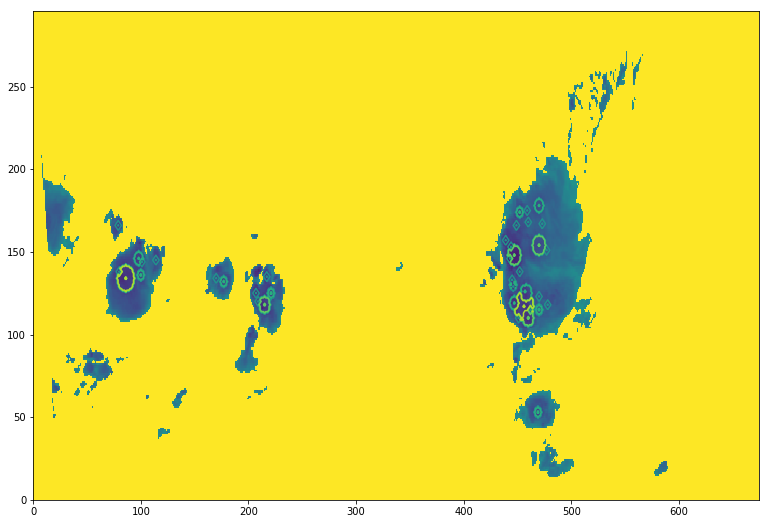

In [1338]:
plt.figure(figsize=(13,9))
plt.pcolormesh(msg_imgg)
plt.contour(ar_msg['blobs'][day,y1:y2,x1:x2])

In [1339]:
mfg_img, mfg_nogood, mfg_min, mfg_max = filter_img(mfg_imgg)
msg_img, msg_nogood, msg_min, msg_max = filter_img(msg_imgg)

outmin 0.0 79.0
xmin 0.3448275862068966
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
outmin 0.0 82.52
xmin 0.30750307503075036
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [1340]:
mfg_nogood

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

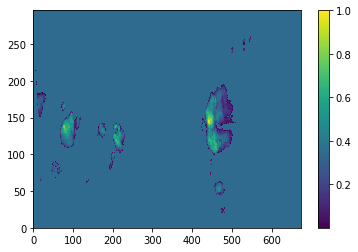

In [1341]:
plt.pcolormesh(mfg_img)
plt.colorbar()

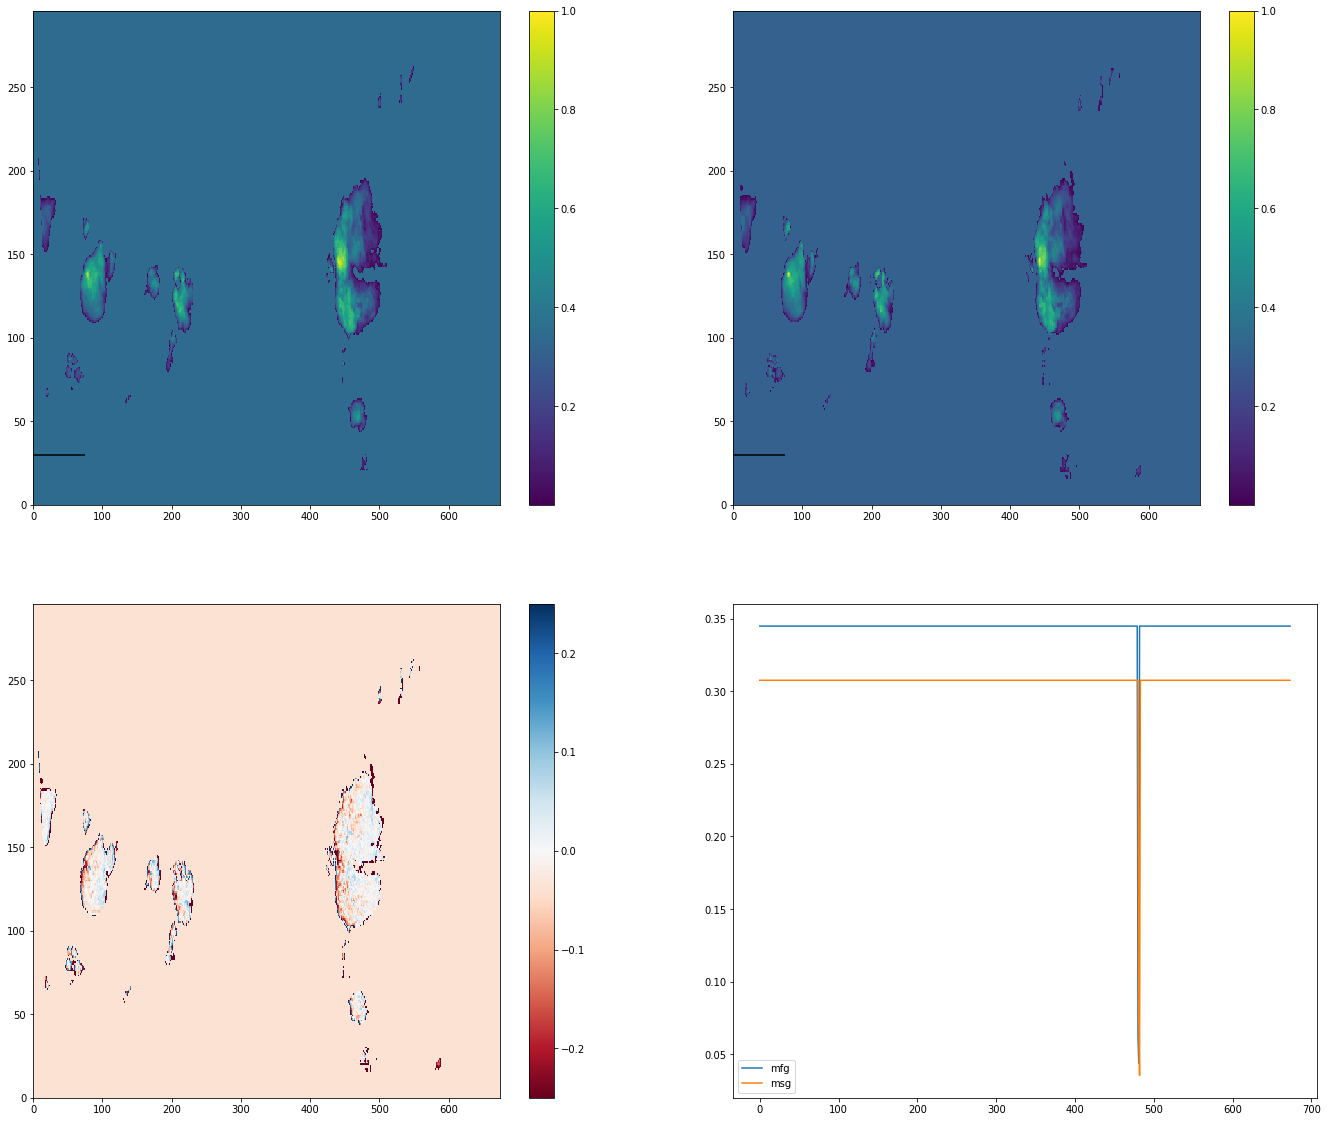

In [1342]:
f = plt.figure(figsize=(23,20))
ax = f.add_subplot(221)
plt.pcolormesh(mfg_img)
plt.hlines(y=30, xmin=0, xmax=75)
plt.colorbar()
ax = f.add_subplot(222)
plt.pcolormesh(msg_img)
plt.hlines(y=30, xmin=0, xmax=75)
plt.colorbar()
ax = f.add_subplot(223)
plt.pcolormesh(msg_img-mfg_img, cmap='RdBu', vmin=-0.25, vmax=0.25)
plt.colorbar()
ax = f.add_subplot(224)
plt.plot(mfg_img[30,:], label='mfg')
plt.plot(msg_img[30,:], label='msg')

plt.legend()

In [1343]:
mfg_pow = util.waveletT_normalised(mfg_img, dataset='METEOSAT5K_vera')
msg_pow = util.waveletT_normalised(msg_img, dataset='METEOSAT5K_vera')

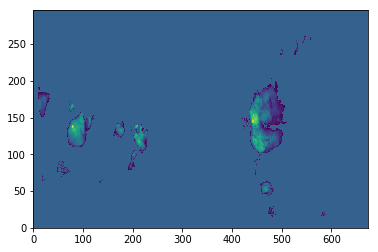

In [1344]:
plt.pcolormesh(msg_img)

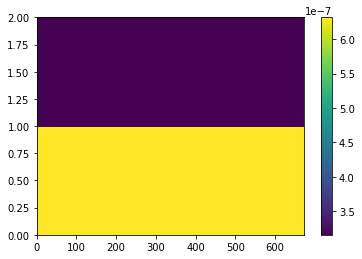

In [1345]:
plt.pcolormesh(msg_pow['t'][:,0,:])
plt.colorbar()

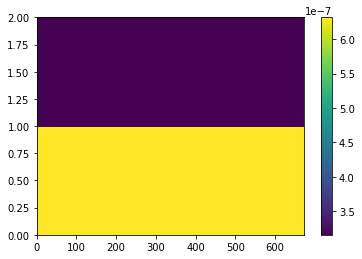

In [1346]:
plt.pcolormesh(mfg_pow['t'][:,0,:])
plt.colorbar()

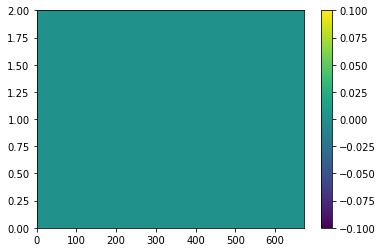

In [1347]:
plt.pcolormesh(msg_pow['t'][:,0,:]-mfg_pow['t'][:,0,:])
plt.colorbar()

In [1348]:
arr = msg_pow['scales']

In [1349]:
arr

array([25.        , 35.35533906])

In [1]:
def find_scales_dominant(wav, outt,core_min=None, no_good=None):
    outt[no_good] = np.nan

    arr = np.array(wav['scales'], dtype=str)

    scale_ind = range(arr.size)

    figure = np.zeros_like(outt)

    wll = wav['t']

    maxoutt = (
        wll == ndimage.maximum_filter(wll, (5,4,4), mode='reflect',   # 5,4,4
                                      cval=np.amax(wll) + 1))  # (np.round(orig / 5))

    yyy = []
    xxx = []
    scal = []
    scale_list = []
    
    power_img = np.sum(wll, axis=0)
    power_img[no_good] = 0
    
    for nb in scale_ind[::-1]:

        orig = float(arr[nb])

        scale = int(np.round(orig))

        #print(np.round(orig))

        wl = wll[nb, :, :]
        wl[no_good] = 0
        maxout = maxoutt[nb, :, :]

        try:
            yy, xx = np.where((maxout == 1) & (outt >= core_min)  &  (wl > orig**.5)) #  #  &
        except IndexError:
            continue

        #print(outt[yy,xx])
        if len(outt[yy,xx]) >=1:
            scale_list.append((np.round(orig), outt[yy,xx]))

        for y, x in zip(yy, xx):

            ss = orig
            iscale = (np.ceil(ss / 2. / 5.)).astype(int)

            ycirc, xcirc = ua.draw_cut_circle(x, y, iscale, outt)

            figure[ycirc, xcirc] = scale  #outt
            figure[y,x] = scale * -1
            xxx.append(x)
            yyy.append(y)
            scal.append(orig)
    print(scale_list)
    return figure, power_img

In [1351]:
def find_scales_small(wav, outt,core_min=None, no_good=None):
    outt[no_good] = np.nan

    arr = np.array(wav['scales'], dtype=str)

    scale_ind = range(arr.size)

    figure = np.zeros_like(outt)

    wll = wav['t']

    yyy = []
    xxx = []
    scal = []
    scale_list = []
    
    power_img = np.sum(wll, axis=0)
    power_img[no_good] = 0
    
    for nb in scale_ind[::-1]:

        orig = float(arr[nb])

        scale = int(np.round(orig))

        #print(np.round(orig))

        wl = wll[nb, :, :]
        #wl[no_good] = 0
        #maxout = maxoutt[nb, :, :]
        
        print('min power threshold', (orig**.5), np.max(wl))
        
        maxout = (
            wl == ndimage.maximum_filter(wl, (5, 5), mode='reflect', cval=np.amax(wl) + 1))  # (np.round(orig / 5))

        try:
            yy, xx = np.where((maxout == 1) & (outt >= core_min)) #  #  &
        except IndexError:
            continue

        #print(outt[yy,xx])
        if len(outt[yy,xx]) >=1:
            scale_list.append((np.round(orig), outt[yy,xx]))

        for y, x in zip(yy, xx):
            
            if no_good[y,x]:
                continue
            
            ss = orig
            iscale = (np.ceil(ss / 2. / 5.)).astype(int)

            ycirc, xcirc = ua.draw_cut_circle(x, y, iscale, outt)

            figure[ycirc, xcirc] = scale  #outt
            figure[y,x] = scale * -1
            xxx.append(x)
            yyy.append(y)
            scal.append(orig)
    print(scale_list)
    return figure, power_img

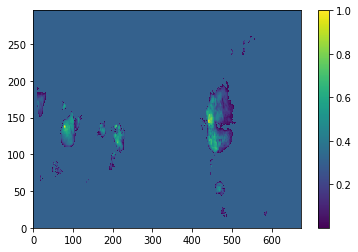

In [1352]:
#msg_img[msg_nogood] = np.nan
plt.pcolormesh(msg_img)
plt.colorbar()

In [1353]:
fig_msg, power_msg = find_scales_small(msg_pow, msg_img, no_good=msg_nogood, core_min=normalised(65,msg_min, msg_max))

min power threshold 5.946035575013606 0.031869228361517635
min power threshold 5.0 0.02700573532178412
[(35.0, array([0.46740467, 0.51353014, 0.550123  , ..., 0.48646986, 0.49354244,
       0.51076261])), (25.0, array([0.46740467, 0.51353014, 0.550123  , 0.54182042, 0.47478475,
       0.52736777, 0.53075031, 0.51906519, 0.50768758, 0.48277983,
       0.48554736, 0.46494465, 0.5098401 , 0.53751538, 0.48616236,
       0.46279213, 0.46186962, 0.48462485, 0.50061501, 0.49292743,
       0.51137761, 0.5104551 , 0.49077491, 0.57687577, 0.56549815,
       0.55504305, 0.60424354, 0.62207872, 0.58179582, 0.60209102,
       0.62915129, 0.54766298, 0.58425584, 0.5999385 , 0.63468635,
       0.66328413, 0.59932349, 0.67466175, 0.67220172, 0.64268143,
       0.59194342, 0.60239852, 0.55781058, 0.59102091, 0.63314883,
       0.66943419, 0.66482165, 0.63253383, 0.69095941, 0.63099631,
       0.58671587, 0.54059041, 0.69065191, 0.65867159, 0.62546125,
       0.61469865, 0.59840098, 0.54458795, 0.468327

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal


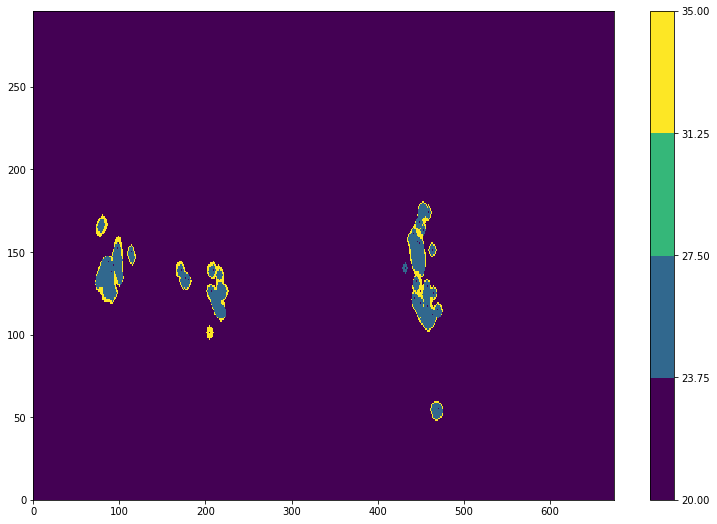

In [1354]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(20,35,5) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('viridis')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.figure(figsize=(13,9))

plt.contourf(msg_img, levels=np.arange(0,1,0.1), vmin=normalised(65,msg_min, msg_max))
plt.pcolormesh(fig_msg, norm=norm)
plt.colorbar()

In [1355]:
fig_mfg, power_mfg = find_scales_small(mfg_pow, mfg_img, no_good=mfg_nogood, core_min=normalised(65,mfg_min, mfg_max))

min power threshold 5.946035575013606 0.027334412069661175
min power threshold 5.0 0.026410836412276054
[(35.0, array([0.55172414, 0.55172414, 0.55172414, ..., 0.54758621, 0.53448276,
       0.52517241])), (25.0, array([0.55172414, 0.55172414, 0.55172414, 0.55172414, 0.55172414,
       0.5862069 , 0.60896552, 0.61827586, 0.58965517, 0.62275862,
       0.63827586, 0.5862069 , 0.5862069 , 0.64482759, 0.67206897,
       0.6237931 , 0.63275862, 0.65517241, 0.65517241, 0.60724138,
       0.56413793, 0.56413793, 0.57724138, 0.66034483, 0.68965517,
       0.65517241, 0.65517241, 0.65517241, 0.65517241, 0.58517241,
       0.73310345, 0.67931034, 0.65517241, 0.65517241, 0.63413793,
       0.57241379, 0.51758621, 0.70172414, 0.66206897, 0.65517241,
       0.65517241, 0.63482759, 0.56172414, 0.66      , 0.68448276,
       0.65517241, 0.65517241, 0.63551724, 0.56275862, 0.51931034,
       0.52137931, 0.52172414, 0.64793103, 0.65724138, 0.65517241,
       0.64758621, 0.5862069 , 0.58344828, 0.53862

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal


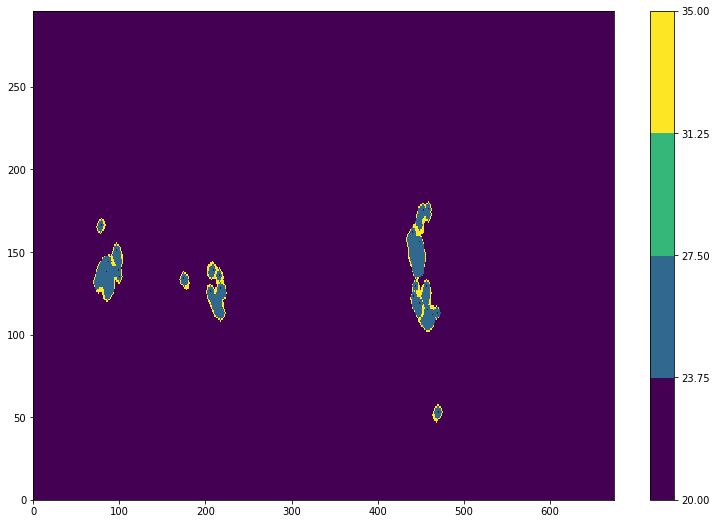

In [1356]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = np.linspace(20,35,5) #MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('viridis')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.figure(figsize=(13,9))

plt.contourf(mfg_img, levels=np.arange(0,1,0.1), vmin=normalised(65,mfg_min, mfg_max))
plt.pcolormesh(fig_mfg, norm=norm)
plt.colorbar()

In [1357]:
power_mfg[mfg_nogood] = 0
power_msg[msg_nogood] = 0

In [1358]:
np.unique(fig_msg)

array([-35., -25.,   0.,  25.,  35.])

In [1359]:
figmsg = (fig_msg < 30) &  (fig_msg>0)
figmfg = (fig_mfg < 30) &  (fig_mfg>0)

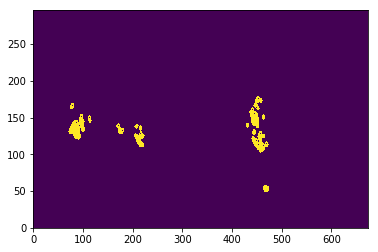

In [1360]:
plt.pcolormesh(figmsg)

In [1361]:
np.sum(figmsg)-np.sum(figmfg)

322

In [1362]:
(np.sum(figmsg)-np.sum(figmfg))/np.sum(figmsg)

0.12864562524970036

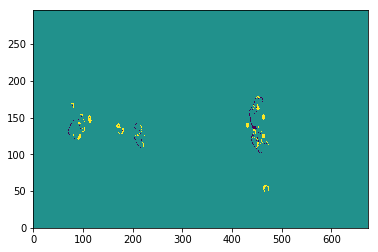

In [1363]:
plt.pcolormesh(figmsg.astype(int)-figmfg.astype(int))

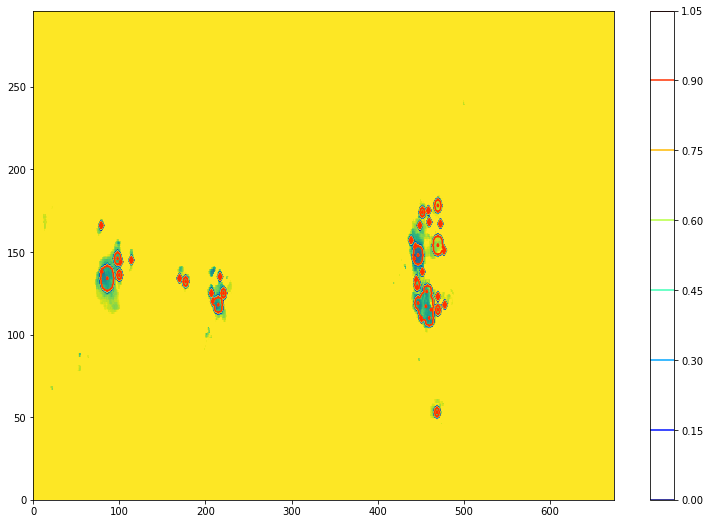

In [1376]:
plt.figure(figsize=(13,9))

plt.pcolormesh(msg_imgg, vmax=-60)
#plt.contour(figmsg)
plt.contour((tmsg['blobs'].values>0), cmap='jet')
plt.colorbar()

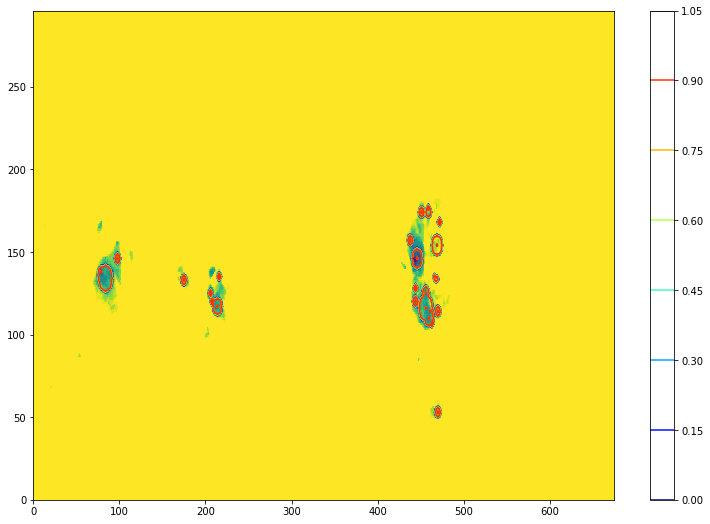

In [1377]:
plt.figure(figsize=(13,9))

plt.pcolormesh(mfg_imgg, vmax=-60)
#plt.contour(figmsg)
plt.contour((tmfg['blobs'].values>0), cmap='jet')
plt.colorbar()